In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import timm
from PIL import Image
import os
import warnings
import kagglehub

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

In [3]:
DEVICE = torch.device("cuda")

In [4]:
IMAGE_SIZE_B0 = 224 
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_EPOCHS = 10

In [5]:
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):

        original_index = index
        
        while True:
            path, target = self.samples[index]
            
            try:
                img = self.loader(path) 
                
                if self.transform is not None:
                    img = self.transform(img)
                
                return img, target

            except Exception as e:
                print(f"Error (skip): {path}. Error: {e}")
                
                index = (index + 1) % len(self.samples)
                
                if index == original_index:
                    raise RuntimeError("pass")

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_B0, IMAGE_SIZE_B0)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_B0, IMAGE_SIZE_B0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [7]:
ROOT_KAGGLE_DIR = str(kagglehub.dataset_download('imbikramsaha/food11'))

In [8]:
FOOD11_ROOT = os.path.join(ROOT_KAGGLE_DIR, 'food11')
TRAIN_DIR = os.path.join(FOOD11_ROOT, 'train')
VAL_DIR = os.path.join(FOOD11_ROOT, 'test')

In [9]:
train_dataset = SafeImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = SafeImageFolder(root=VAL_DIR, transform=val_transforms)

In [10]:
NUM_CLASSES = len(train_dataset.classes)
print(NUM_CLASSES)

11


In [11]:
train_loader_b0 = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

val_loader_b0 = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [12]:
model = timm.create_model('efficientnet_b0', pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features 
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"total {total_params:,}")
print(f"trained {trainable_params:,}")

model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

total 4,021,639
trained 14,091


In [13]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [14]:
def plot_confusion_matrix(cm, class_names, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader):
    best_f1 = 0.0
    best_cm = None 

    for epoch in range(num_epochs):
        print(f"\n--- epoch {epoch+1}/{num_epochs} ---")

        model.train()  
        running_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f"Train E{epoch+1}", leave=False)

        for inputs, labels in train_bar:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            train_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        print(f"train loss {epoch_loss:.4f}")

        model.eval()  
        
        all_labels = []
        all_preds = []

        val_bar = tqdm(val_loader, desc=f"Valid E{epoch+1}", leave=False)

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                
                _, preds = torch.max(outputs, 1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
        cm = confusion_matrix(all_labels, all_preds)
        
        print(f"val acc {val_accuracy:.4f} | F1 {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_cm = cm

    print(f"best f1 {best_f1:.4f}")
    
    return model, best_cm, train_dataset.classes

In [16]:
final_model, final_cm, class_names = train_model(model, criterion, optimizer, scheduler, NUM_EPOCHS, train_loader_b0, val_loader_b0)


--- epoch 1/10 ---


Train E1:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 1.2908


Valid E1:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7009 | F1 0.6972

--- epoch 2/10 ---


Train E2:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.8798


Valid E2:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7382 | F1 0.7371

--- epoch 3/10 ---


Train E3:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7899


Valid E3:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7400 | F1 0.7378

--- epoch 4/10 ---


Train E4:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7516


Valid E4:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7500 | F1 0.7500

--- epoch 5/10 ---


Train E5:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7036


Valid E5:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7582 | F1 0.7580

--- epoch 6/10 ---


Train E6:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6600


Valid E6:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7582 | F1 0.7577

--- epoch 7/10 ---


Train E7:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6552


Valid E7:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7591 | F1 0.7590

--- epoch 8/10 ---


Train E8:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6535


Valid E8:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7582 | F1 0.7582

--- epoch 9/10 ---


Train E9:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6543


Valid E9:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7573 | F1 0.7568

--- epoch 10/10 ---


Train E10:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6599


Valid E10:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7573 | F1 0.7565
best f1 0.7590


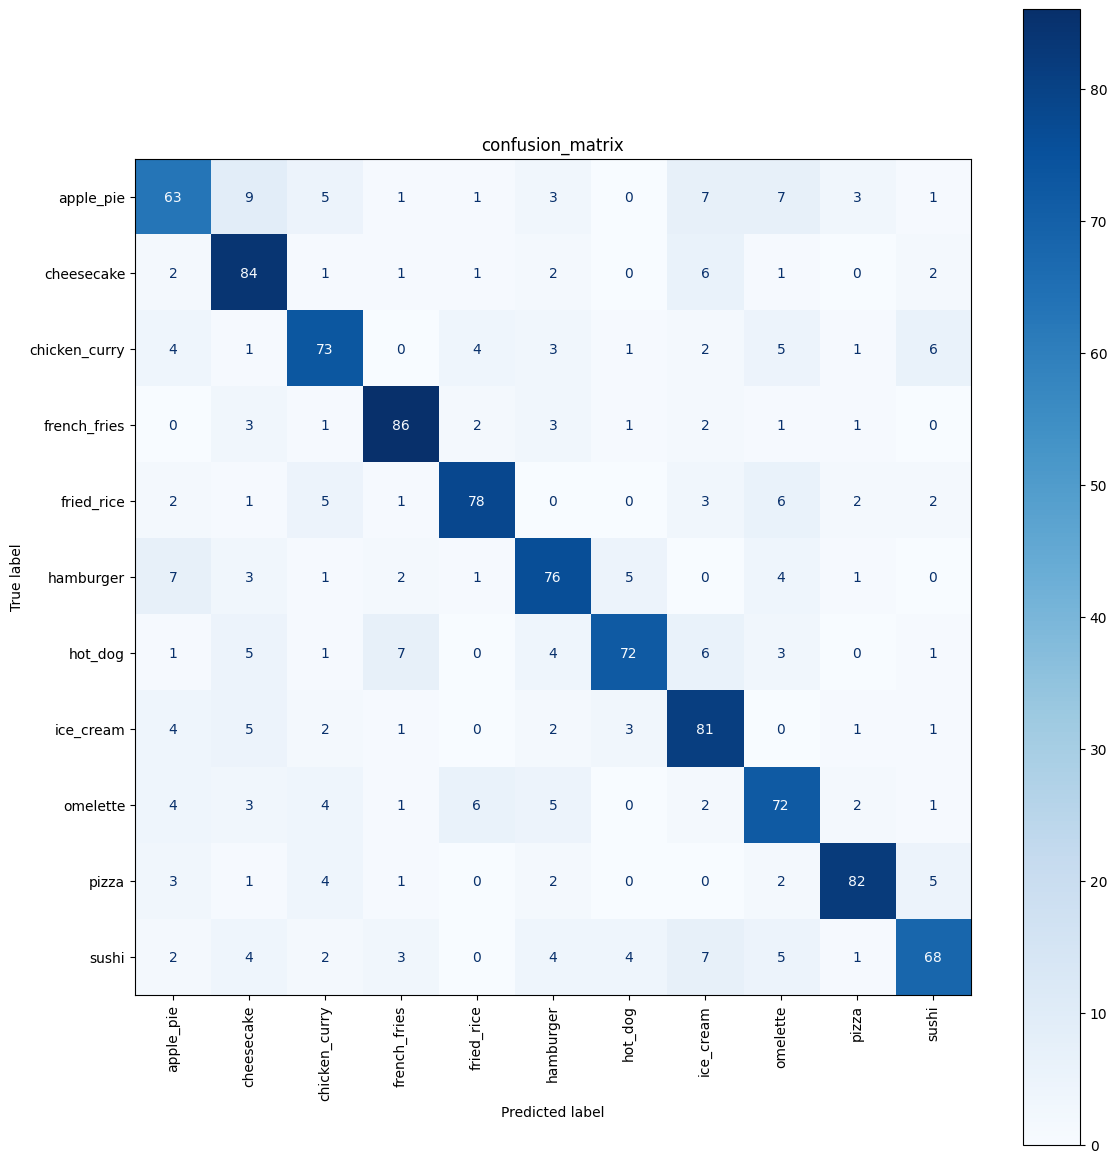

In [17]:
plot_confusion_matrix(final_cm, class_names, "confusion_matrix")

In [18]:
IMAGE_SIZE_B1 = 240

In [19]:
train_transforms_b1 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_B1, IMAGE_SIZE_B1)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transforms_b1 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_B1, IMAGE_SIZE_B1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [20]:
train_dataset.transform = train_transforms_b1
val_dataset.transform = val_transforms_b1

train_loader_b1 = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

val_loader_b1 = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [21]:
model_b1 = timm.create_model('efficientnet_b1', pretrained=True)

for param in model_b1.parameters():
    param.requires_grad = False

num_ftrs_b1 = model_b1.classifier.in_features 
model_b1.classifier = nn.Linear(num_ftrs_b1, NUM_CLASSES)

model_b1.to(DEVICE)

criterion_b1 = nn.CrossEntropyLoss()
optimizer_b1 = optim.AdamW(model_b1.classifier.parameters(), lr=0.001) 
scheduler_b1 = optim.lr_scheduler.StepLR(optimizer_b1, step_size=5, gamma=0.1)

In [22]:
final_model_b1, final_cm_b1, class_names_b1 = train_model(model_b1, criterion_b1, optimizer_b1, scheduler_b1, NUM_EPOCHS, train_loader_b1, val_loader_b1)


--- epoch 1/10 ---


Train E1:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 1.2758


Valid E1:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7136 | F1 0.7073

--- epoch 2/10 ---


Train E2:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.8597


Valid E2:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7418 | F1 0.7413

--- epoch 3/10 ---


Train E3:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7860


Valid E3:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7327 | F1 0.7336

--- epoch 4/10 ---


Train E4:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7744


Valid E4:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7318 | F1 0.7318

--- epoch 5/10 ---


Train E5:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7240


Valid E5:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7382 | F1 0.7385

--- epoch 6/10 ---


Train E6:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6842


Valid E6:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7455 | F1 0.7457

--- epoch 7/10 ---


Train E7:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6861


Valid E7:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7427 | F1 0.7433

--- epoch 8/10 ---


Train E8:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6872


Valid E8:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7400 | F1 0.7405

--- epoch 9/10 ---


Train E9:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6795


Valid E9:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7336 | F1 0.7337

--- epoch 10/10 ---


Train E10:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6674


Valid E10:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7336 | F1 0.7347
best f1 0.7457


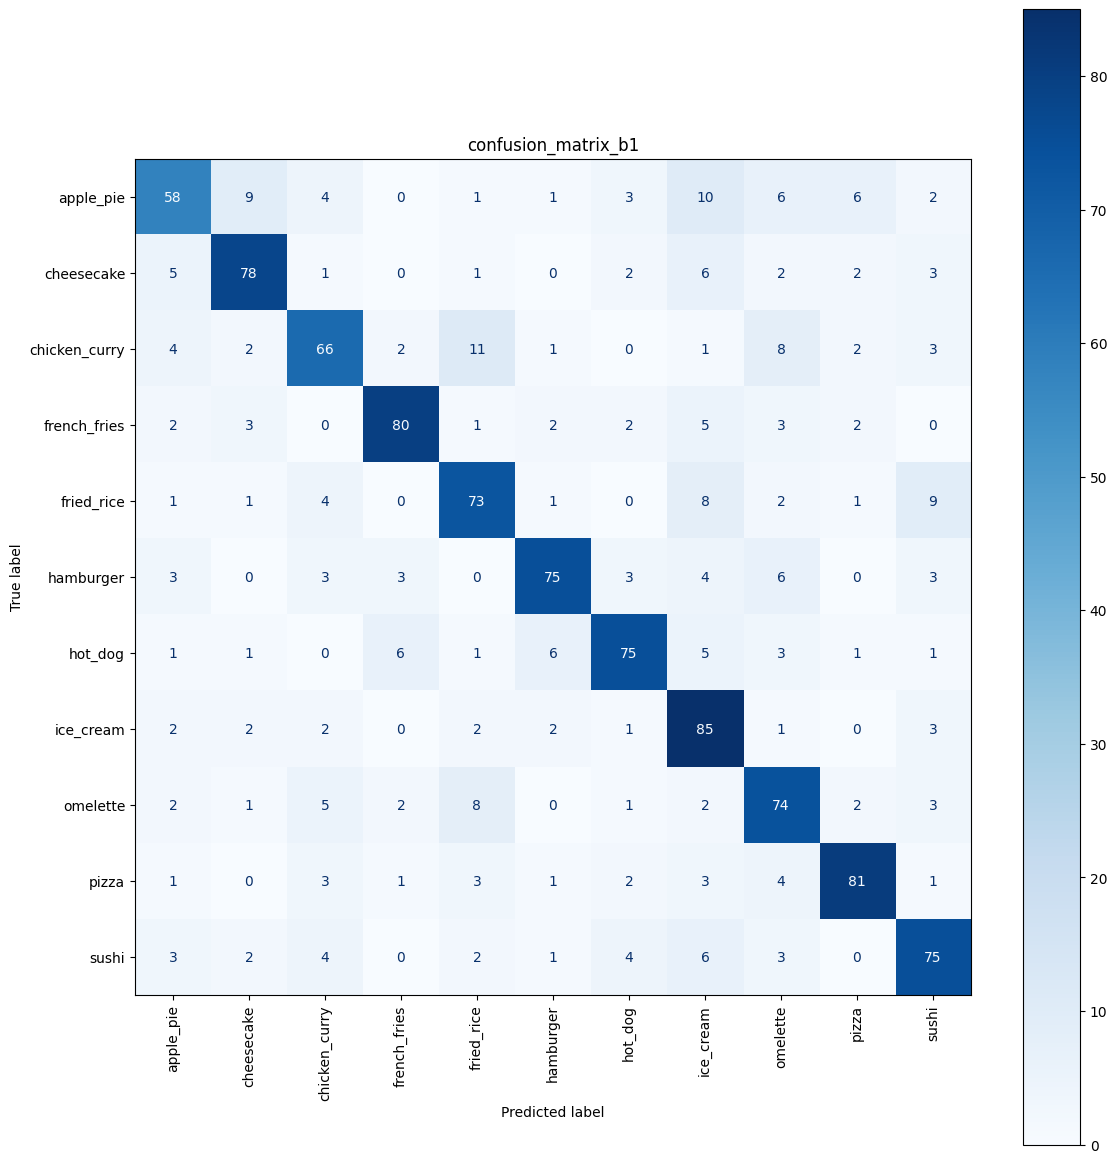

In [23]:
plot_confusion_matrix(final_cm_b1, class_names_b1, "confusion_matrix_b1")

In [24]:
IMAGE_SIZE_B2 = 260

In [25]:
train_transforms_b2 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_B2, IMAGE_SIZE_B2)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transforms_b2 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_B2, IMAGE_SIZE_B2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [26]:
train_dataset.transform = train_transforms_b2
val_dataset.transform = val_transforms_b2

train_loader_b2 = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True 
)

val_loader_b2 = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [27]:
model_b2 = timm.create_model('efficientnet_b2', pretrained=True)

for param in model_b2.parameters():
    param.requires_grad = False

num_ftrs_b2 = model_b2.classifier.in_features 
model_b2.classifier = nn.Linear(num_ftrs_b2, NUM_CLASSES)

model_b2.to(DEVICE)

criterion_b2 = nn.CrossEntropyLoss()
optimizer_b2 = optim.AdamW(model_b2.classifier.parameters(), lr=0.001) 
scheduler_b2 = optim.lr_scheduler.StepLR(optimizer_b2, step_size=5, gamma=0.1)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [28]:
final_model_b2, final_cm_b2, class_names_b2 = train_model(model_b2, criterion_b2, optimizer_b2, scheduler_b2, NUM_EPOCHS, train_loader_b2, val_loader_b2)


--- epoch 1/10 ---


Train E1:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 1.2055


Valid E1:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7500 | F1 0.7528

--- epoch 2/10 ---


Train E2:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7678


Valid E2:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7782 | F1 0.7783

--- epoch 3/10 ---


Train E3:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6736


Valid E3:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7773 | F1 0.7761

--- epoch 4/10 ---


Train E4:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6295


Valid E4:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8036 | F1 0.8028

--- epoch 5/10 ---


Train E5:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5941


Valid E5:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7991 | F1 0.7987

--- epoch 6/10 ---


Train E6:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5579


Valid E6:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8018 | F1 0.8018

--- epoch 7/10 ---


Train E7:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5593


Valid E7:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7936 | F1 0.7930

--- epoch 8/10 ---


Train E8:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5525


Valid E8:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8045 | F1 0.8046

--- epoch 9/10 ---


Train E9:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5508


Valid E9:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8018 | F1 0.8013

--- epoch 10/10 ---


Train E10:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5458


Valid E10:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7918 | F1 0.7916
best f1 0.8046


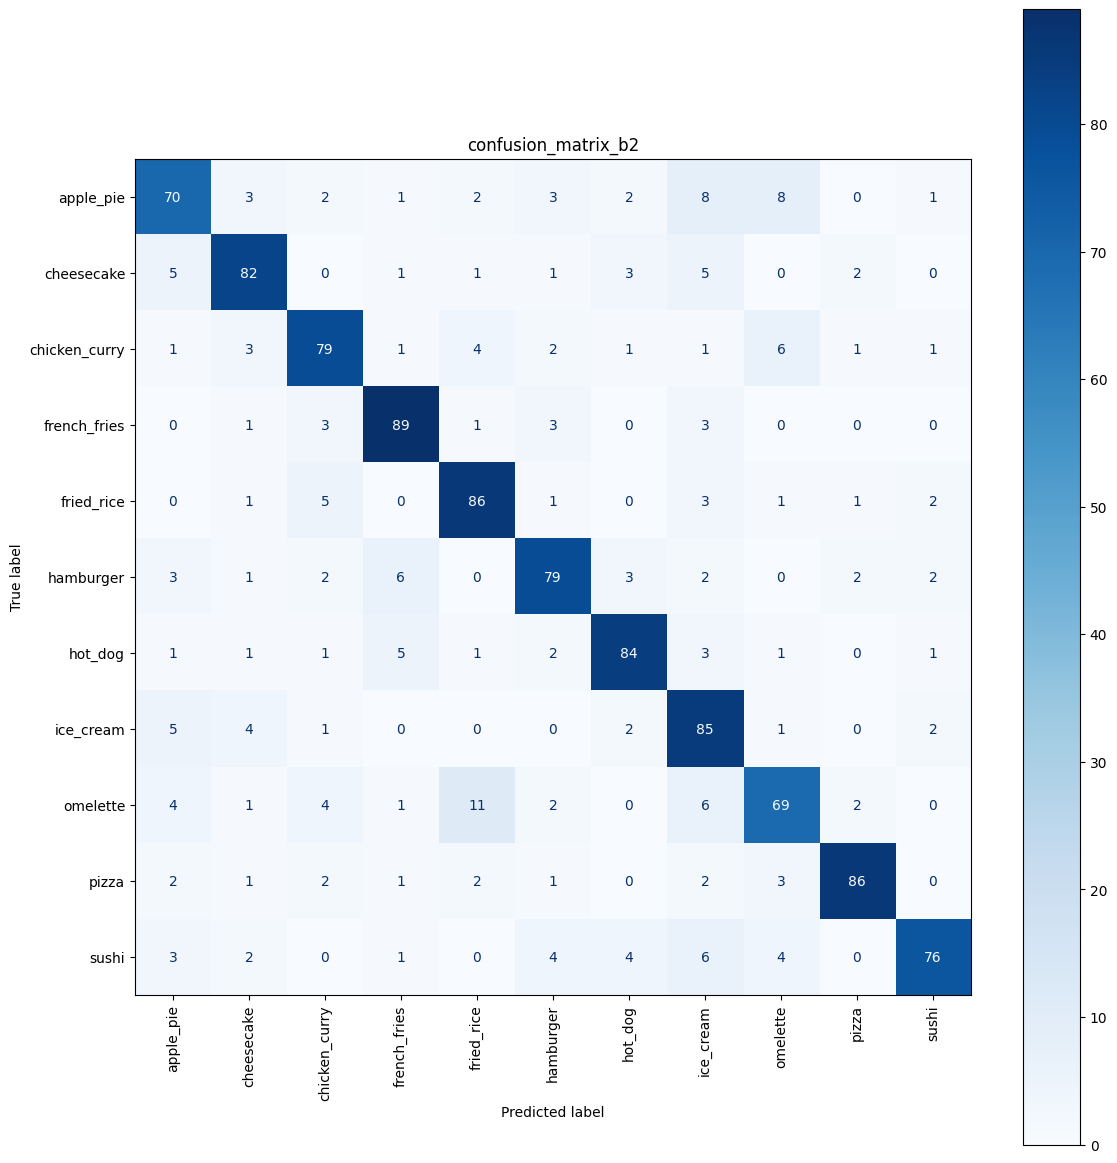

In [29]:
plot_confusion_matrix(final_cm_b2, class_names_b2, "confusion_matrix_b2")

In [30]:
IMAGE_SIZE_RN = 224 
NUM_CLASSES = len(train_dataset.classes)

In [31]:
rn_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_RN, IMAGE_SIZE_RN)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),     
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_rn_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE_RN, IMAGE_SIZE_RN)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
train_dataset.transform = rn_transforms
val_dataset.transform = val_rn_transforms

In [33]:
train_loader_rn = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader_rn = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

In [34]:
import torchvision.models as models

In [49]:
model_rn50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

In [36]:
for param in model_rn50.parameters():
    param.requires_grad = False

In [37]:
num_ftrs_rn = model_rn50.fc.in_features
model_rn50.fc = nn.Linear(num_ftrs_rn, NUM_CLASSES)

In [38]:
model_rn50.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
criterion_rn50 = nn.CrossEntropyLoss()
optimizer_rn50 = optim.AdamW(model_rn50.fc.parameters(), lr=0.001) 
scheduler_rn50 = optim.lr_scheduler.StepLR(optimizer_rn50, step_size=5, gamma=0.1)

In [40]:
final_model_rn50, final_cm_rn50, class_names_rn50 = train_model(
    model_rn50, criterion_rn50, optimizer_rn50, scheduler_rn50, NUM_EPOCHS, train_loader_rn, val_loader_rn
)


--- epoch 1/10 ---


Train E1:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 1.1720


Valid E1:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7627 | F1 0.7616

--- epoch 2/10 ---


Train E2:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7928


Valid E2:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7682 | F1 0.7661

--- epoch 3/10 ---


Train E3:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7359


Valid E3:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7582 | F1 0.7549

--- epoch 4/10 ---


Train E4:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7094


Valid E4:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7836 | F1 0.7867

--- epoch 5/10 ---


Train E5:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6983


Valid E5:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7909 | F1 0.7924

--- epoch 6/10 ---


Train E6:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6137


Valid E6:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7982 | F1 0.7996

--- epoch 7/10 ---


Train E7:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6064


Valid E7:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8045 | F1 0.8054

--- epoch 8/10 ---


Train E8:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6040


Valid E8:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8009 | F1 0.8001

--- epoch 9/10 ---


Train E9:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6054


Valid E9:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7964 | F1 0.7962

--- epoch 10/10 ---


Train E10:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6018


Valid E10:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8109 | F1 0.8112
best f1 0.8112


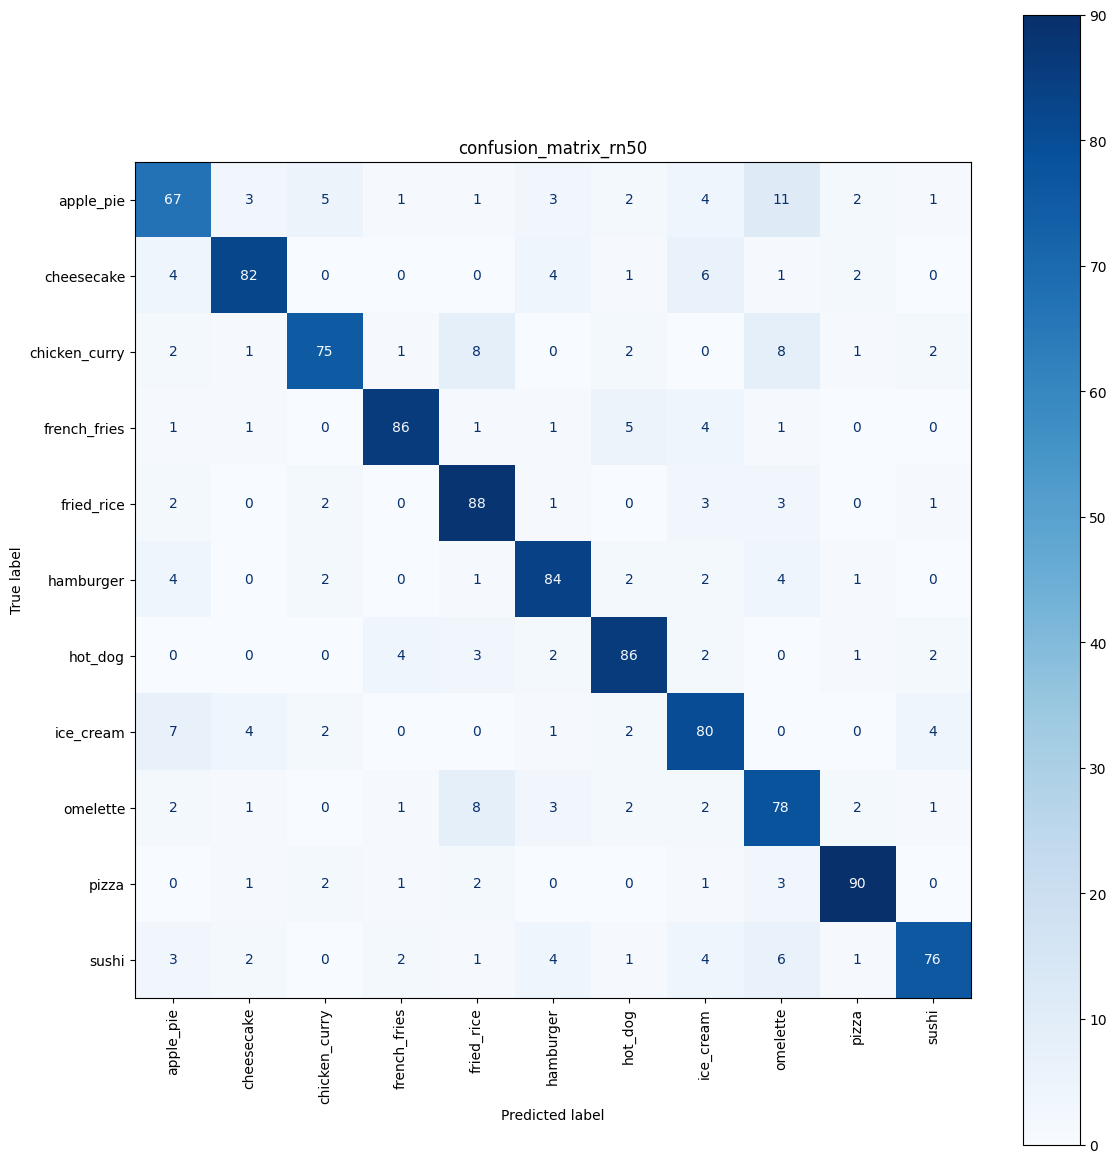

In [41]:
plot_confusion_matrix(final_cm_rn50, class_names_rn50, "confusion_matrix_rn50")

In [50]:
model_dn121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [43]:
for param in model_dn121.parameters():
    param.requires_grad = False

In [44]:
num_ftrs_dn = model_dn121.classifier.in_features
model_dn121.classifier = nn.Linear(num_ftrs_dn, NUM_CLASSES)

In [45]:
model_dn121.to(DEVICE)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [46]:
criterion_dn121 = nn.CrossEntropyLoss()
optimizer_dn121 = optim.AdamW(model_dn121.classifier.parameters(), lr=0.001) 
scheduler_dn121 = optim.lr_scheduler.StepLR(optimizer_dn121, step_size=5, gamma=0.1)

In [47]:
final_model_dn121, final_cm_dn121, class_names_dn121 = train_model(
    model_dn121, criterion_dn121, optimizer_dn121, scheduler_dn121, NUM_EPOCHS, train_loader_rn, val_loader_rn
)


--- epoch 1/10 ---


Train E1:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 1.2957


Valid E1:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7336 | F1 0.7376

--- epoch 2/10 ---


Train E2:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.8159


Valid E2:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7782 | F1 0.7764

--- epoch 3/10 ---


Train E3:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.7324


Valid E3:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7655 | F1 0.7660

--- epoch 4/10 ---


Train E4:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6825


Valid E4:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7718 | F1 0.7727

--- epoch 5/10 ---


Train E5:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6585


Valid E5:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7882 | F1 0.7899

--- epoch 6/10 ---


Train E6:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6158


Valid E6:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7945 | F1 0.7952

--- epoch 7/10 ---


Train E7:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6025


Valid E7:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7936 | F1 0.7936

--- epoch 8/10 ---


Train E8:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6139


Valid E8:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.8009 | F1 0.8010

--- epoch 9/10 ---


Train E9:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.5967


Valid E9:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7964 | F1 0.7966

--- epoch 10/10 ---


Train E10:   0%|          | 0/310 [00:00<?, ?it/s]

train loss 0.6063


Valid E10:   0%|          | 0/18 [00:00<?, ?it/s]

val acc 0.7991 | F1 0.7992
best f1 0.8010


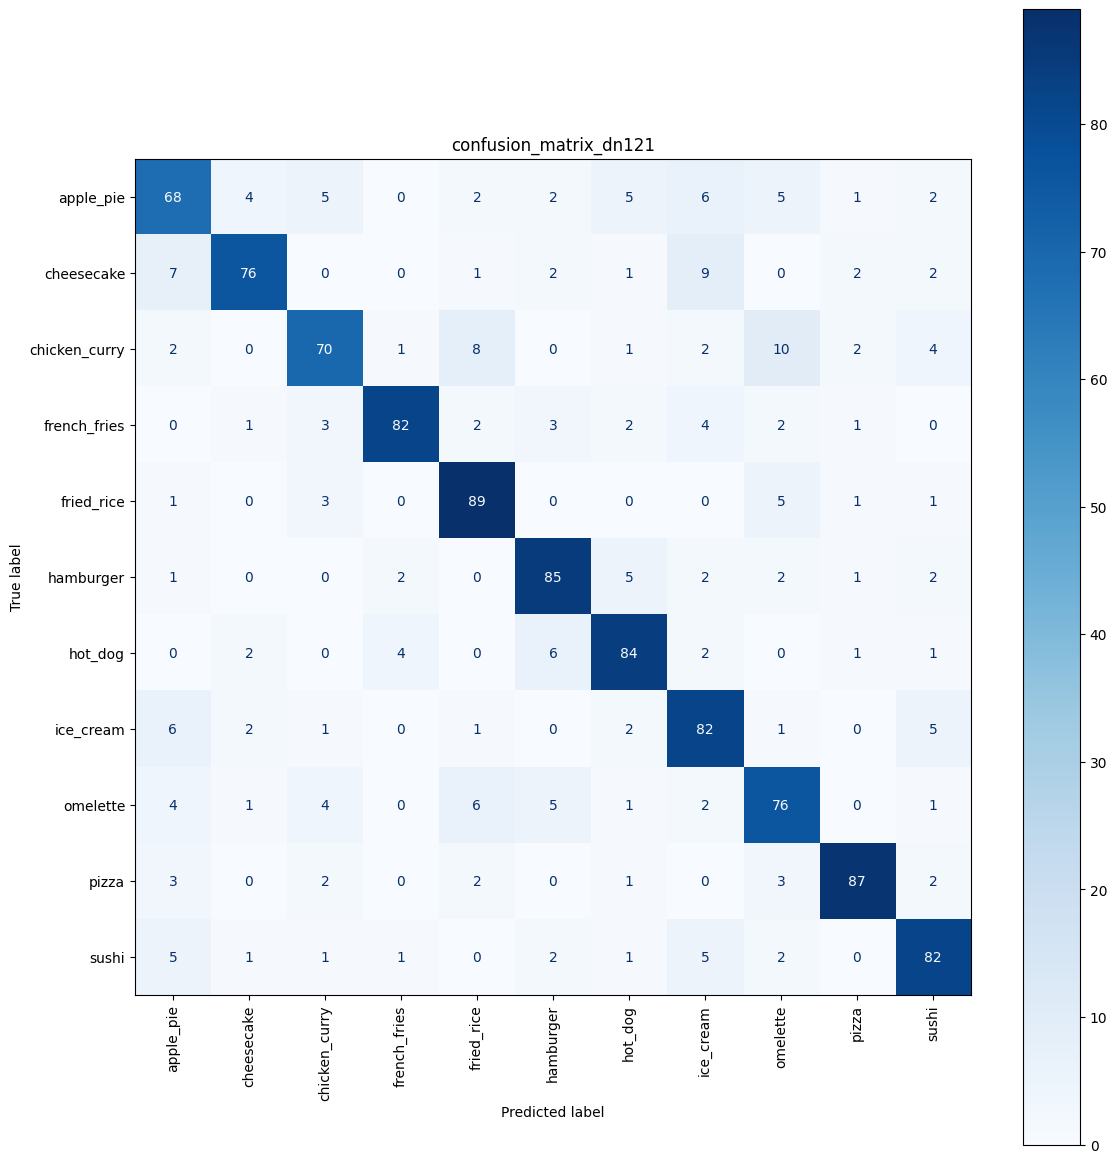

In [48]:
plot_confusion_matrix(final_cm_dn121, class_names_dn121, "confusion_matrix_dn121")